In [1]:
import numpy as np, pandas as pd, csv, matplotlib.pyplot as plt, os, re, json, seaborn as sns 
from numpy import exp, pi, sinc, sin, tan, convolve, square, abs, arcsin, arctan, sqrt, cos, shape, array, mean,exp 
from collections import defaultdict 
from scipy.optimize import curve_fit 
from sklearn.linear_model import LinearRegression
from scipy.ndimage import median_filter
from typing import List


from concurrent.futures import ThreadPoolExecutor 
import multiprocessing as mp

py_blue = '#1f77b4' 
py_orange = '#ff7f0e' 
py_green = '#2ca02c'

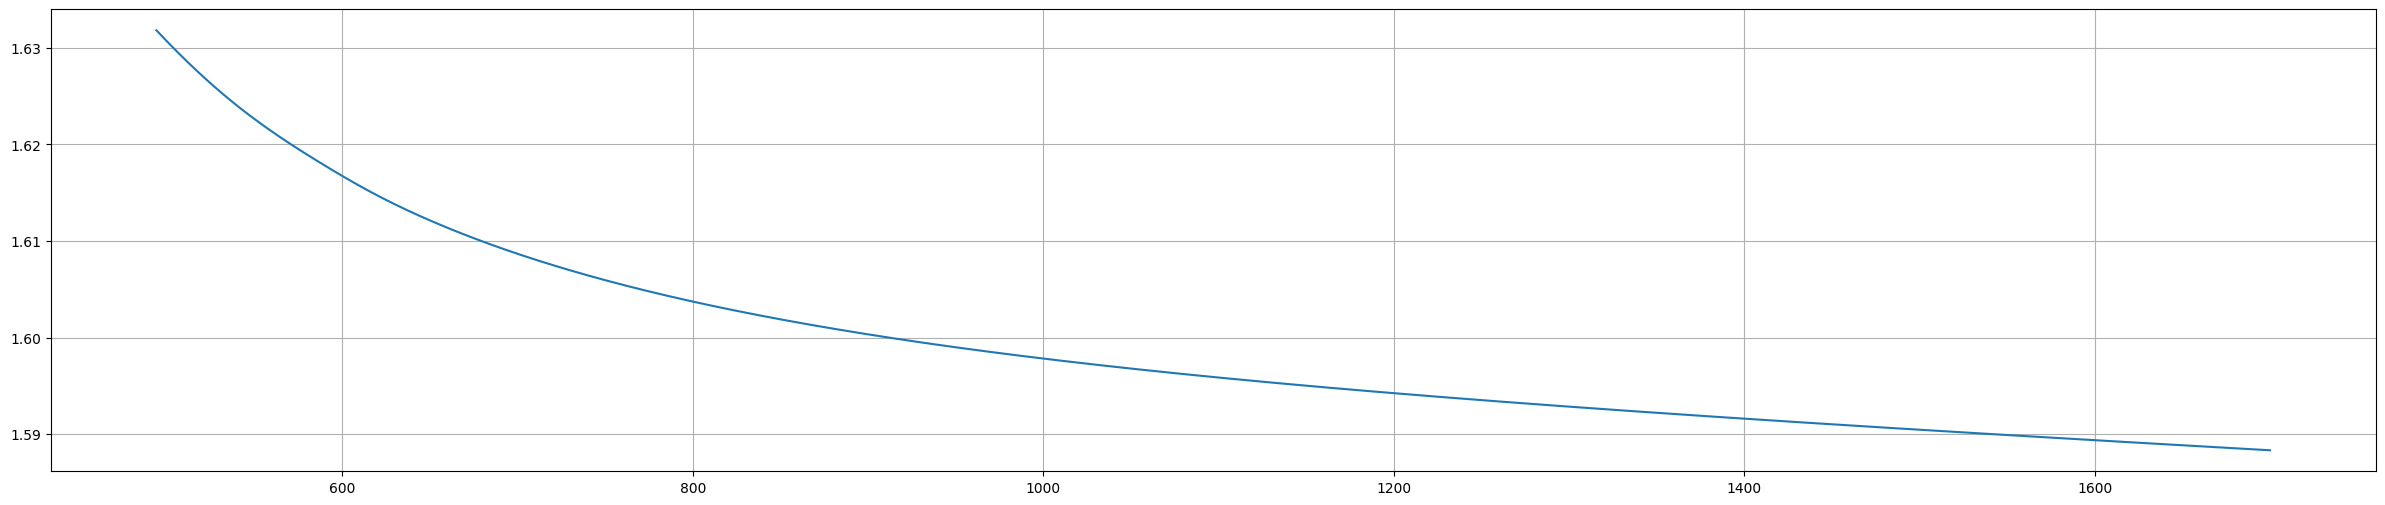

In [2]:
resist = pd.read_csv('/kaggle/input/better-refractive-index/maP1275.mat', delimiter = '\t')
resist.columns = ['wavelength', 'real', 'im']
resist.wavelength = resist.wavelength*0.1
plt.figure(figsize = (30,6))
plt.grid()
#plt.plot(resist.wavelength, resist.real)
#plt.plot(resist.wavelength, resist.im)
refractive_index = np.sqrt(resist.real[300:])
plt.plot(resist.wavelength[300:], refractive_index)
new_refractive = pd.DataFrame({'wavelength':resist.wavelength[300:], 'refractive_index': refractive_index})
new_refractive.to_csv('new_refractive.csv')

#wavelengths_um = np.arange(500,1600)*1e-3
#n = sqrt(1 + 0.6961663*wavelengths_um**2/(wavelengths_um**2 - 0.0684043**2) + 0.4079426*wavelengths_um**2/(wavelengths_um**2 - 0.1162414**2) + 0.8974794*wavelengths_um**2/(wavelengths_um**2 - 9.896161**2))
#plt.plot(np.arange(500,1600), n)


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[1.58613820e+00 1.11122725e+04 4.00000000e-05]


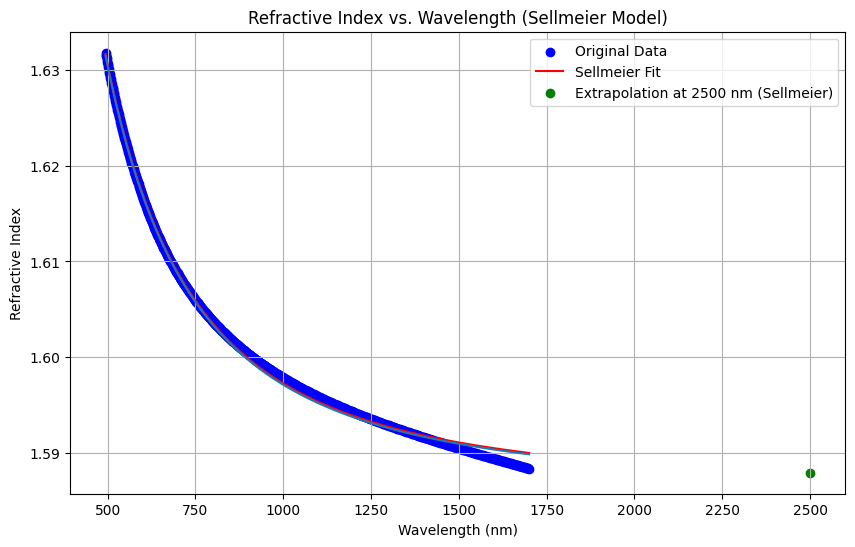

In [3]:
# Define the Sellmeier equation function
def sellmeier_eq(wavelength, a,b,c):
    return a + b * wavelength**-2 + c * wavelength**-4

# Initial guess for the Sellmeier coefficients
initial_guess = [1.5, 0.007, 0.00004]
wavelengths = resist.wavelength[300:]

# Perform the curve fitting
sellmeier_params, sellmeier_covariance = curve_fit(sellmeier_eq, wavelengths, refractive_index, p0=initial_guess)
print(sellmeier_params)

# Use the fitted model to generate refractive indices for plotting
refractive_indices_sellmeier_fit = sellmeier_eq(wavelengths, *sellmeier_params)

# Extrapolate the refractive index at 2500 nm using the fitted Sellmeier equation
predicted_index_2500nm_sellmeier = sellmeier_eq(2500, *sellmeier_params)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(wavelengths, refractive_index, color='blue', label='Original Data')
plt.plot(wavelengths, refractive_indices_sellmeier_fit, color='red', label='Sellmeier Fit')
plt.plot(wavelengths, 1.586 + 1.111e4* wavelengths**-2 + 4e-5*wavelengths**-4)
plt.scatter([2500], [predicted_index_2500nm_sellmeier], color='green', label='Extrapolation at 2500 nm (Sellmeier)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Refractive Index')
plt.title('Refractive Index vs. Wavelength (Sellmeier Model)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_19/1642948084.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  blaze = pd.read_csv('/kaggle/input/linear-blaze/blaze linear', delimiter= '  ', dtype = float, header= 3)


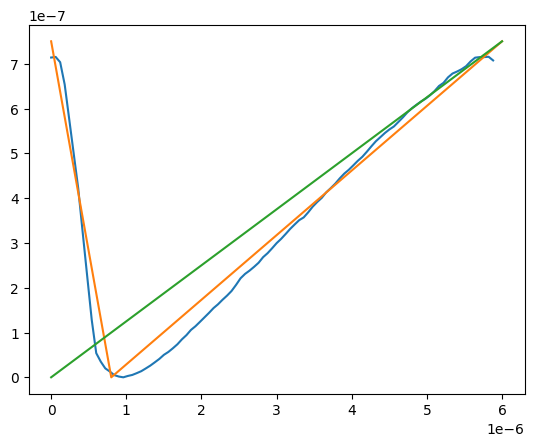

In [4]:
blaze = pd.read_csv('/kaggle/input/linear-blaze/blaze linear', delimiter= '  ', dtype = float, header= 3)
blaze.columns = ['x', 'y']
height = blaze.y[59:158] - min(blaze.y[45:144])
length = blaze.x[59:158] - min(blaze.x[59:158])
plt.plot(length, height)
plt.plot([0,0.8e-6, 6e-6], [7.5e-7, 0, 7.5e-7])
plt.plot([0,6e-6], [0, 7.5e-7])
one_blaze = pd.DataFrame({'x': length, 'y':height})
one_blaze.to_csv('blaze.csv')

[-9.56943909 -1.34105694  0.28572123  7.97745284]


/tmp/ipykernel_19/3295759465.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  blaze = pd.read_csv('/kaggle/input/blaze-profile/blaze profile', delimiter= '  ', dtype = float)


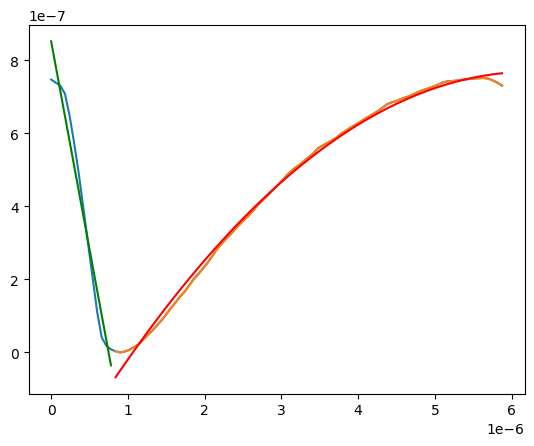

In [5]:
blaze = pd.read_csv('/kaggle/input/blaze-profile/blaze profile', delimiter= '  ', dtype = float)
blaze.columns = ['x', 'y']
height = blaze.y[48:147] - min(blaze.y[45:144])
length = blaze.x[45:144] - min(blaze.x[45:144])
plt.plot(length, height)

sep = -85
height2, length2 = height[sep:], length[sep:]
height1, length1 = height[:sep], length[:sep]
plt.plot(length2, height2)

quadratic = 1e5*(length2- 3.8e-6)**2

def oblique(length2, shift_x, shift_y, width, beta):
    return (length2-shift_x) * tan(np.radians(beta)) - width*quadratic + shift_y

def linear(length1, shift, orientation):
    return length1*orientation + shift

popt_oblique, pcov = curve_fit(oblique, length2, height2)#, bounds=(0, [3., 1., 0.5]))
print(popt_oblique)

popt_linear, pcov = curve_fit(linear, length1, height1)


#y2 = (x2-0.9e-6) * tan(np.radians(8.2)) - 0.3*quadratic + 2e-7
#plt.plot(x2, y2, color = py_orange)
plt.plot(length2, oblique(length2, *popt_oblique), color = 'red')
plt.plot(length1, linear(length1, *popt_linear), color = 'green')
#plt.plot(x2, quadratic)
#plt.plot([0,6e-6], [0, 7.5e-7])

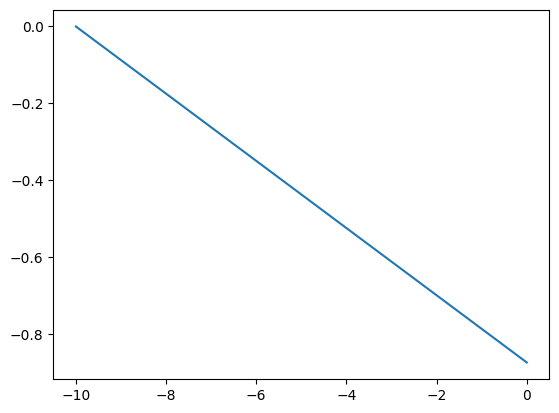

In [6]:
x = np.linspace(-10, 0,100)
y = tan(np.radians(5)) * (-10 - x) 
plt.plot(x, y)

# Diffraction modeling

/tmp/ipykernel_19/954838016.py:23: RuntimeWarning: invalid value encountered in arcsin
  self.angles = np.arcsin(sin(self.incident_angles)[:, np.newaxis, np.newaxis] + np.outer(self.orders, self.wavelengths)[np.newaxis, :]/self.period)


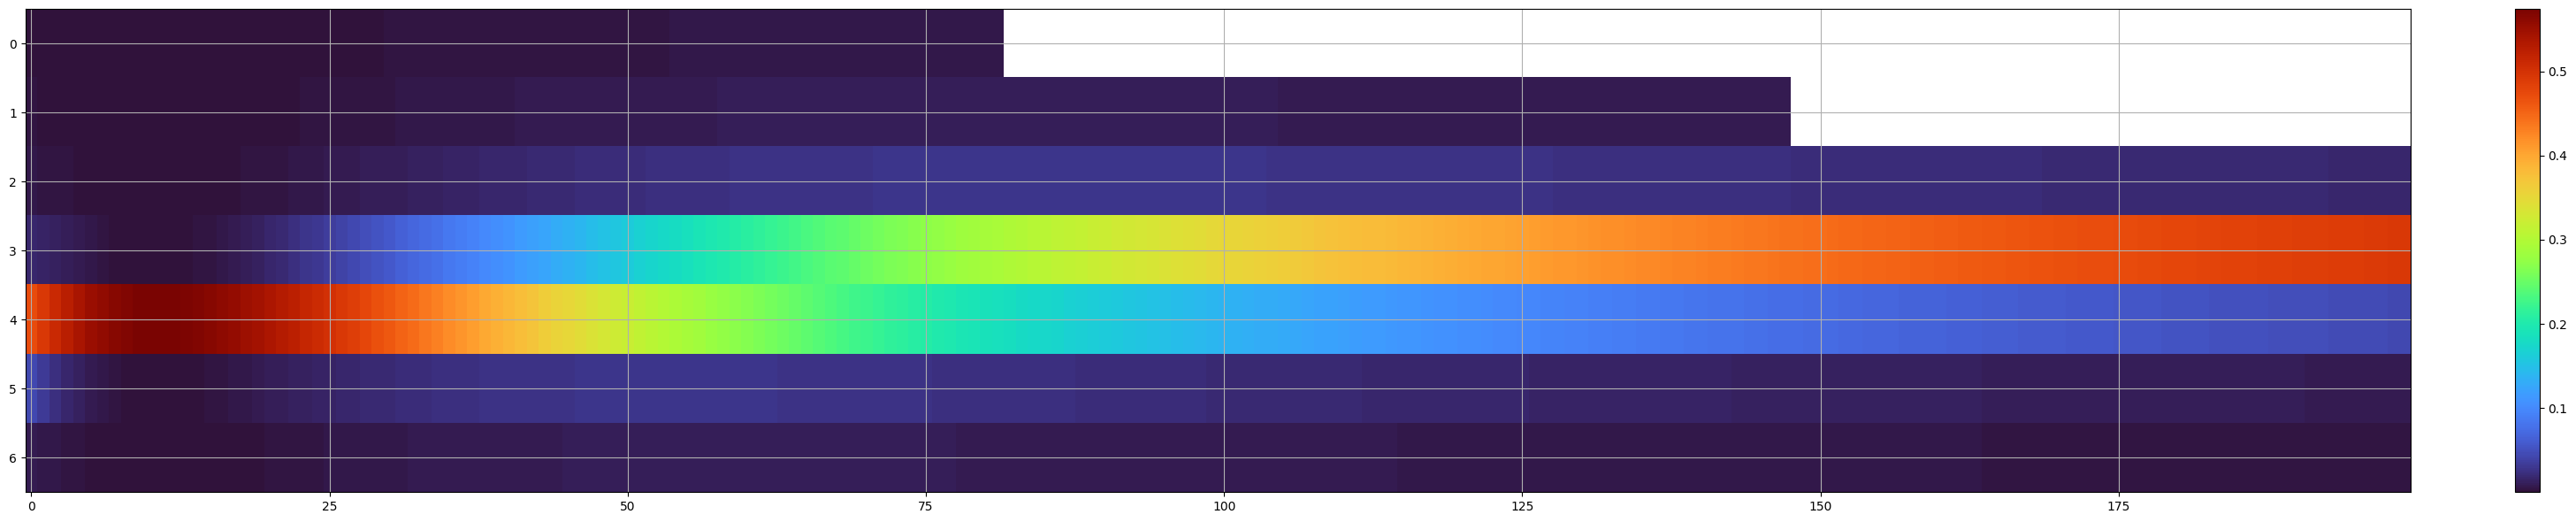

In [7]:
class DiffractionModel:
    """Class for modeling diffraction efficiencies

    Attributes:
        wavelengths (List[int]): list of wavelengths[nm] for which to calculate efficiencies
        orders (List[int]): list of diffraction orders to calculate efficiencies for
        incident_angles (List[int]): list of incident angles for the calculation
        period (int): gratin period in [nm]
    Methods:
        __init__: Initializes the class.
        _reflect: Calculates reflectance efficiencies
        _trans: Calculates transmittance efficiencies
    """
    
    def __init__(self, wavelengths: List[int], orders: List[int], incident_angles: List[int], period: int):
        self.separator = 0
        self.period = period * 1e-9
        self.right_period = period * 1e-9 * (1-self.separator)
        self.left_period = period * 1e-9 * self.separator
        self.wavelengths = np.array(wavelengths) * 1e-9 
        self.orders = orders
        self.incident_angles = np.array(incident_angles)/180*np.pi
        self.angles = np.arcsin(sin(self.incident_angles)[:, np.newaxis, np.newaxis] + np.outer(self.orders, self.wavelengths)[np.newaxis, :]/self.period)
        self.frequencies = np.sin(self.angles) / self.wavelengths
        self.height = (75*self.period/1e-6 + 300)*1e-9
        self.blaze_angle = np.arctan(self.height/self.right_period) * 1.3
        self.slope_angle = np.arctan(self.height/self.left_period) if self.left_period > 0 else 0
        self.n = 1.586 + 1.111e4* np.power(np.array(wavelengths, dtype = float), -2) + 4e-5*np.power(np.array(wavelengths, dtype = float), -4)
        #self.reflx_s_intensity, self.reflx_p_intensity = self._calculate_reflx_intensities()
        self.trans_s_intensity, self.trans_p_intensity = self._calculate_trans_intensities()

    def _calculate_reflx_intensities(self):
        """
        Returns diffraction efficiencies in reflection for s and p polarisation in shape shape of (orders, incident angles, wavelengths).
        """
        tilted_incident_angles = self.incident_angles - self.blaze_angle
        trans_angles = arcsin(np.outer(tilted_incident_angles, 1/self.n)) - self.blaze_angle
        rs_coef = (cos(tilted_incident_angles)[:, np.newaxis] - cos(trans_angles)* self.n) / (cos(tilted_incident_angles)[:, np.newaxis] + cos(trans_angles)* self.n)
        rp_coef = (np.outer(cos(tilted_incident_angles), self.n) - cos(trans_angles)) / (np.outer(cos(tilted_incident_angles), self.n) + cos(trans_angles))
        
        offset = -2* tan(self.blaze_angle) + sin(self.incident_angles)
        offset = np.outer(offset, 1/self.wavelengths)[: , np.newaxis, :]
        s_intensity = square(abs((rs_coef[:, np.newaxis, :]+1) * sinc((self.frequencies + offset)*self.period)))
        p_intensity = square(abs((rp_coef[:, np.newaxis, :]+1) * sinc((self.frequencies + offset)*self.period)))
        return s_intensity, p_intensity

    def _calculate_trans_intensities(self):
        ts_coef, tp_coef = self._calcualate_ts_tp_coef()
        offset_right = ((self.n[np.newaxis, :]-1)*tan(self.blaze_angle) + sin(self.incident_angles)[: , np.newaxis])/self.wavelengths
        offset_left = ((1-self.n[np.newaxis, :])*tan(self.slope_angle) + sin(self.incident_angles)[: , np.newaxis])/self.wavelengths
        
        f1_transform = sinc((self.frequencies-offset_right[:, np.newaxis, :])*self.right_period*(1-self.separator))*(1-self.separator)
        f2_transform = sinc((self.frequencies-offset_left[:, np.newaxis, :])*self.left_period*self.separator)*self.separator
        f_transform = f1_transform + f2_transform
        
        s_intensity =  square(abs(ts_coef[:, np.newaxis, :] * f_transform))
        p_intensity =  square(abs(tp_coef[:, np.newaxis, :] * f_transform))
        return s_intensity, p_intensity
    
    def _calcualate_ts_tp_coef(self):
        tilted_incident_angles = self.incident_angles - self.blaze_angle
        trans_angles = arcsin(np.outer(sin(tilted_incident_angles), 1/self.n)) - self.blaze_angle
        ts_coef = 2*cos(tilted_incident_angles)[:, np.newaxis]  / (np.outer(cos(tilted_incident_angles), self.n) + cos(trans_angles))
        tp_coef = 2*cos(tilted_incident_angles)[:, np.newaxis]  / (cos(trans_angles) + self.n + cos(tilted_incident_angles)[:, np.newaxis])
        return ts_coef, tp_coef

def compare(incident_angle: int, mode: str = 'trans', polarisation: str = 'S'):
        """ Displays the measured diffraction efficiencies alongside the modeled ones in two separate heatmaps for the angles of incidence and modes provided. """
        if mode not in ['trans', 'reflx']: raise ValueError("Mode must be 'trans' or 'reflx'.")
        model = DiffractionModel(range(500,2500,10), [-3,-2,-1,0,1,2,3], range(-20,20,10), 6_000)
        index = np.where(np.array(range(-20,20,10)) == incident_angle)[0]
        model_intensity = np.squeeze(model.trans_s_intensity[index])
        #fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
        plt.figure(figsize = (30,6))
        im = plt.imshow(model_intensity, cmap='turbo', aspect = 'auto')#, vmin=0, vmax=1)
        plt.grid()
        plt.colorbar(im,orientation='vertical', fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.savefig('comparison.png')
        
compare(-20)

# Envelope

TODO:
* change zero order filename ( add start and stop )
* orders and inc angles

In [8]:
class Envelope:
    """Class containing diffraction data loaded and processed by the FileProcessor.

    Attributes:
        directory_path (str): Path to directory containing the scans

    Methods:
        show_shifts: showing relations of peaks shift to statistically relevant values
        show_diffraction: plotting the obtained diffraction peaks for each order and incident angle
        compare: comparing the modeled efficiency heatmap to the efficiency heatmap measured

    """
    def __init__(self, data, incident_angles, orders, wavelengths, measured_s_trans, measured_p_trans, measured_s_reflx, measured_p_reflx):
        self.data = data
        self.incident_angles = incident_angles
        print('Incident angles: ')
        print(incident_angles)
        self.orders = orders
        print('Orders:')
        print(orders)
        self.wavelengths = wavelengths
        self.measured_s_trans = measured_s_trans
        self.measured_p_trans = measured_p_trans
        self.measured_s_reflx = measured_s_reflx
        self.measured_p_reflx = measured_p_reflx
        self.model_efficiency = DiffractionModel(self.wavelengths, self.orders, self.incident_angles, 6_000)
        
    def show_peaks(self, orders: list=None, incident_angles: list=None, mode: str='trans', polarisation: str='S'):
        """
        Displays the diffraction measurements for each selcted order and angles of incidence

        Parameters:
        - orders(list): determines measurements of which order will be shown
        - incident_angles(list):  determines angles of incidence for which measurements will be shown
        - mode(str): determines whether to show measurements for transmission, reflection or both
        """
        orders = orders or self.orders
        incident_angles = incident_angles or self.incident_angles
        mode = mode or 'trans'
        title = 'Transmittance' if mode == 'trans' else 'Reflectance'
        for i in incident_angles:
            fig, axes = plt.subplots(nrows=len(orders), ncols=1, figsize=(20, 20))
            for m, ax in zip(orders, axes):
                df = self.data[(self.data['mode'] == mode) & (self.data['polarisation'] ==  polarisation) & (self.data['order'] ==  m) & (self.data['incident_angle'] ==  i)]
                for index, row in df.iterrows():
                    ax.plot(row['wavelengths'], row['intensity'], label = str(m))
                ax.set_title( title + ' order: ' + str(m) + ', angle of incidence:   ' +str(i))
                ax.set_ylabel(title + ' efficiency')
                ax.set_xlabel('Wavelengths [nm]')
                ax.set_xlim(min(self.wavelengths), max(self.wavelengths))
            plt.tight_layout()
            plt.savefig('individual.png')
            
    def show_envelope(self, orders: list=None, incident_angles: list=None, mode: str='trans', polarisation: str='S', show_model: bool=True):
        """ Displays the diffraction efficiency curve  for each selcted order and angles of incidence """
        if mode not in ['trans', 'reflx']: raise ValueError("Mode must be 'trans' or 'reflx'.")
        for incident_angle in incident_angles:
            model_intensity, measured_intensity = self._get_intensities(mode, incident_angle, polarisation)
            if orders is None or len(orders) == 0:
                orders = self.orders
            title = 'Transmittance' if mode == 'trans' else 'Reflectance'
            fig, axes = plt.subplots(nrows=len(orders), ncols=1, figsize=(20, 20))
            for m, ax in zip(orders, axes):
                this_order_measured = np.squeeze(measured_intensity[np.where(self.orders ==m)[0]])
                this_order_model = np.squeeze(model_intensity[np.where(self.orders ==m)[0]])
                ax.plot(self.wavelengths, this_order_measured, label = 'Measured (m=' + str(m) + ') efficiency')
                if show_model: ax.plot(self.wavelengths, this_order_model, label = 'Model')
                #ax.set_title( title + ' order: ' + str(m) + ', angle of incidence:   ' +str(incident_angle))
                ax.set_ylabel(title + ' efficiency')
                ax.tick_params(axis="x", labelsize=12)
                ax.tick_params(axis="y", labelsize=12)
                #ax.set_xlabel('Wavelengths [nm]')
                ax.set_xlim(min(self.wavelengths), max(self.wavelengths))
                ax.legend(fontsize = 'x-large')
            plt.xlabel('Wavelengths [nm]', size =20)
            plt.tight_layout()
            plt.savefig('individual.png')

    def compare(self, incident_angle: int, mode: str = 'trans', polarisation: str = 'S'):
        """ Displays the measured diffraction efficiencies alongside the modeled ones in two separate heatmaps for the angles of incidence and modes provided. """
        if mode not in ['trans', 'reflx']: raise ValueError("Mode must be 'trans' or 'reflx'.")
        model_intensity, measured_intensity = self._get_intensities(mode, incident_angle, polarisation)
        
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
        for intensity, ax, title in zip([model_intensity, measured_intensity], axes, ['Model', 'Measurement']):
            im = ax.imshow(intensity, cmap='turbo', extent = [min(self.wavelengths),max(self.wavelengths),  min(self.orders)-0.5, max(self.orders) + 0.5], aspect = 'auto')#, vmin=0, vmax=1)
            ax.set_title(title+' '+ str(incident_angle) +' incident angle in '+ mode, size=22)
            ax.set_xlabel('wavelength [nm]', size = 15)
            ax.set_ylabel('efficiency of mth order', size = 15)
            ax.grid()
            fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.savefig('comparison.png')
        
    def _get_intensities(self, mode, incident_angle, polarisation):
        index = np.where(np.array(self.incident_angles) == incident_angle)[0]
        if index.size == 0: raise ValueError(f"No incident angle matches {incident_angle}.")
        if mode == 'reflx':
            if polarisation == 'S':
                measured_intensity = np.squeeze(self.measured_s_reflx[index])
                model_intensity = np.squeeze(self.model_efficiency.reflx_s_intensity[index])
            if polarisation == 'P':
                measured_intensity = np.squeeze(self.measured_p_reflx[index])
                model_intensity = np.squeeze(self.model_efficiency.reflx_p_intensity[index])
        if mode == 'trans': 
            if polarisation == 'S':
                measured_intensity = np.squeeze(self.measured_s_trans[index])
                model_intensity = np.squeeze(self.model_efficiency.trans_s_intensity[index])
            if polarisation == 'P':
                measured_intensity = np.squeeze(self.measured_p_trans[index])
                model_intensity = np.squeeze(self.model_efficiency.trans_p_intensity[index])
        return model_intensity, measured_intensity

# FileProcessor

In [9]:
class FileProcessor():
    """Static Class for loading scans produced by the sax basic script in CSV format and processing them returning Envelope object.
    
    Methods:
        __init__: Initializes the class.
        _load_curves: Loading the measured curves and corresponding data to a pandas dataframe
        _process_file: Processing raw csv file for intensity and wavelengths
        _get_measured : Converts individual curves stored in a DataFrame to one single numpy array
        _get_shift: determines how much is the recorded peak spectrally shifted from the expected position
    """
    
    @staticmethod
    def from_directory(directory_path: str):
        """ returns Envelope object from provided directory path of scanned csv"""
        files = sorted([os.path.join(directory_path, file) for file in os.listdir(directory_path) if 'S_'in file or 'P_' in file])
        with mp.Pool(processes = os.cpu_count()) as pool:
            processed_data = pool.map(FileProcessor._load_curves, files)
        envelope = FileProcessor._create_envelope(processed_data)
        return envelope

    @staticmethod
    def from_csv(file_path: str):
        """ returns Envelope object from provided csv file containing all the recordings"""
        number_of_recordings = 666 # GENERALIZE LATER
        raw_df = pd.read_csv(file_path, dtype = float,skiprows=[1], nrows = number_of_recordings)
        num_columns = raw_df.shape[1] -3
        processed_data = []
        for i in range(0,num_columns,2):  # We use a step of 4 assuming every dataset spans 4 columns
            pair = FileProcessor._extract_data_pairs(raw_df, i)
            if pair != 0: processed_data.append(pair)
        envelope = FileProcessor._create_envelope(processed_data)
        return envelope
    
    @staticmethod
    def _create_envelope(processed_data):
        """ creates the envelope object from measurement data processed to lists"""
        data = pd.DataFrame(processed_data, columns = ['polarisation', 'order', 'mode', 'angle', 'incident_angle', 'center', 'slope', 'start_w', 'stop_w', 'wavelengths', 'intensity'])
        incident_angles = sorted(data['incident_angle'].unique()) # AUTOMATE
        orders = sorted(data['order'].unique())  # AUTOMATE
        wavelengths  = range(500,2500,4)  # AUTOMATE and include the step in the report
        measured_s_trans = FileProcessor._get_measured('S', 'trans', wavelengths, incident_angles, orders, data)
        measured_s_trans = median_filter(measured_s_trans, size=(1, 1, 3), mode='reflect')
        measured_s_reflx = FileProcessor._get_measured('S', 'reflx', wavelengths, incident_angles, orders, data) 
        measured_s_reflx = median_filter(measured_s_reflx, size=(1, 1, 3), mode='reflect')
        measured_p_trans = FileProcessor._get_measured('P', 'trans', wavelengths, incident_angles, orders, data)
        measured_p_trans = median_filter(measured_p_trans, size=(1, 1, 3), mode='reflect')
        measured_p_reflx = FileProcessor._get_measured('P', 'reflx', wavelengths, incident_angles, orders, data) 
        measured_p_reflx = median_filter(measured_p_reflx, size=(1, 1, 3), mode='reflect')
        return Envelope(data, incident_angles, orders, wavelengths, measured_s_trans, measured_p_trans, measured_s_reflx, measured_p_reflx)    
    
    @staticmethod
    def _extract_data_pairs(df, start_col):
        """ returns processed data arrays from dataframes of wavelengths-intensity pair from main csv"""
        pair_df = df.iloc[:, [start_col, start_col+1]].dropna()  # Drop NaN values which are non-numeric rows
        pair_df = pair_df.apply(pd.to_numeric, errors='coerce')
        pair_df = pair_df.dropna()
        name = pair_df.columns[0]
        info = name.split('_')
        if len(info) > 3:
            data_array = FileProcessor._get_data_array(info, pair_df)
            return data_array
        else:
            return 0
        
    @staticmethod
    def _load_curves(file_path: np.ndarray):
        """ returns processed data arrays from dataframes of wavelengths-intensity pair from main directory"""
        pair_df = pd.read_csv(file_path, header = 1)
        column = pair_df.iloc[:, 1]
        sep_index = column[column.isnull()].index[0]
        pair_df = pair_df.iloc[:sep_index]
        pari_df = pari_df.drop(['Unnamed: 2'], axis = 1)
    
        file_name = file.split('/')[-1]
        info = file_name.split('_')
        data_array = FileProcessor._get_data_array(info, pair_df)
        
        return data_array
    
    @staticmethod
    def _get_data_array(info, pair_df):
        wavelengths = np.array(pair_df.iloc[:, 0])
        intensity = np.array(pair_df.iloc[:, 1])
        polarisation, mode, incident_angle, order, dif_angle, curve_range = info[0], info[2], int(info[5]), int(info[7]), float(info[10]), info[12].split('-')
        start_w = int(curve_range[0])
        stop_w = int(curve_range[1])
        if order == 0: 
            start_w = 500
            stop_w = 2500
        center = int((start_w + stop_w)/2)
        angle = dif_angle + incident_angle
        if mode == 'trans': 
            angle = 180 + angle if angle < 0  else 180 - angle

        usable = min(len(intensity), len(wavelengths))
        intensity = intensity[:usable]
        wavelengths = wavelengths[:usable]
        wavelengths = np.array([w for w, i in zip(wavelengths, intensity) if w % 4 == 0])
        intensity = np.array([i for w, i in zip(wavelengths, intensity) if w % 4 == 0])
        slope = cos(dif_angle/180*pi)/order if order != 0 else 1

        return [polarisation, order, mode, dif_angle, incident_angle, center, slope, start_w, stop_w, wavelengths, intensity]
    
    @staticmethod
    def _get_measured(polarisation: str, mode: str, wavelengths: list, incident_angles: list, orders: list, data: pd.DataFrame):
        """
        Loads diffraction intensities from each measurement stored in a DataFrame to a single numpy array

        Parameters:
        - mode(str): 'trans' or 'reflx' to determine which intensities to load 
        
        Returns:
        - np.array: all the measured intensities for a given mode
        """
        measured = np.full([len(incident_angles), len(orders), len(wavelengths)], np.nan)
        for i in incident_angles:
            for m in orders:
                curve_df = data[(data['order'] == m) & (data['polarisation'] == polarisation) & (data['mode'] == mode) & (data['incident_angle'] == i)]
                for index, row in curve_df.iterrows():
                    if m == 0:
                        start_index = int((row['start_w'] - min(wavelengths))/4)
                        stop_index = int((max(wavelengths) - min(wavelengths))/4)
                        intensity = row['intensity'][:stop_index-start_index]
                        measured[np.where(incident_angles == i)[0][0]][np.where(orders == m)[0][0]][start_index:(start_index+len(intensity))] = intensity[::-1]
                    else:
                        start_index = int((row['start_w'] - min(wavelengths))/4)
                        stop_index = int((row['stop_w'] - min(wavelengths))/4)
                        measured[np.where(incident_angles == i)[0][0]][np.where(orders == m)[0][0]][start_index:stop_index] = row['intensity'][:stop_index-start_index]
        return measured

#daidalos = FileProcessor.from_directory('/kaggle/input/24-eros/12_13')
daidalos = FileProcessor.from_csv('/kaggle/input/measured2/6um_all_envelopes.csv')

Incident angles: 
[-20, 0]
Orders:
[-3, -2, -1, 0, 1, 2, 3]


/tmp/ipykernel_19/954838016.py:23: RuntimeWarning: invalid value encountered in arcsin
  self.angles = np.arcsin(sin(self.incident_angles)[:, np.newaxis, np.newaxis] + np.outer(self.orders, self.wavelengths)[np.newaxis, :]/self.period)


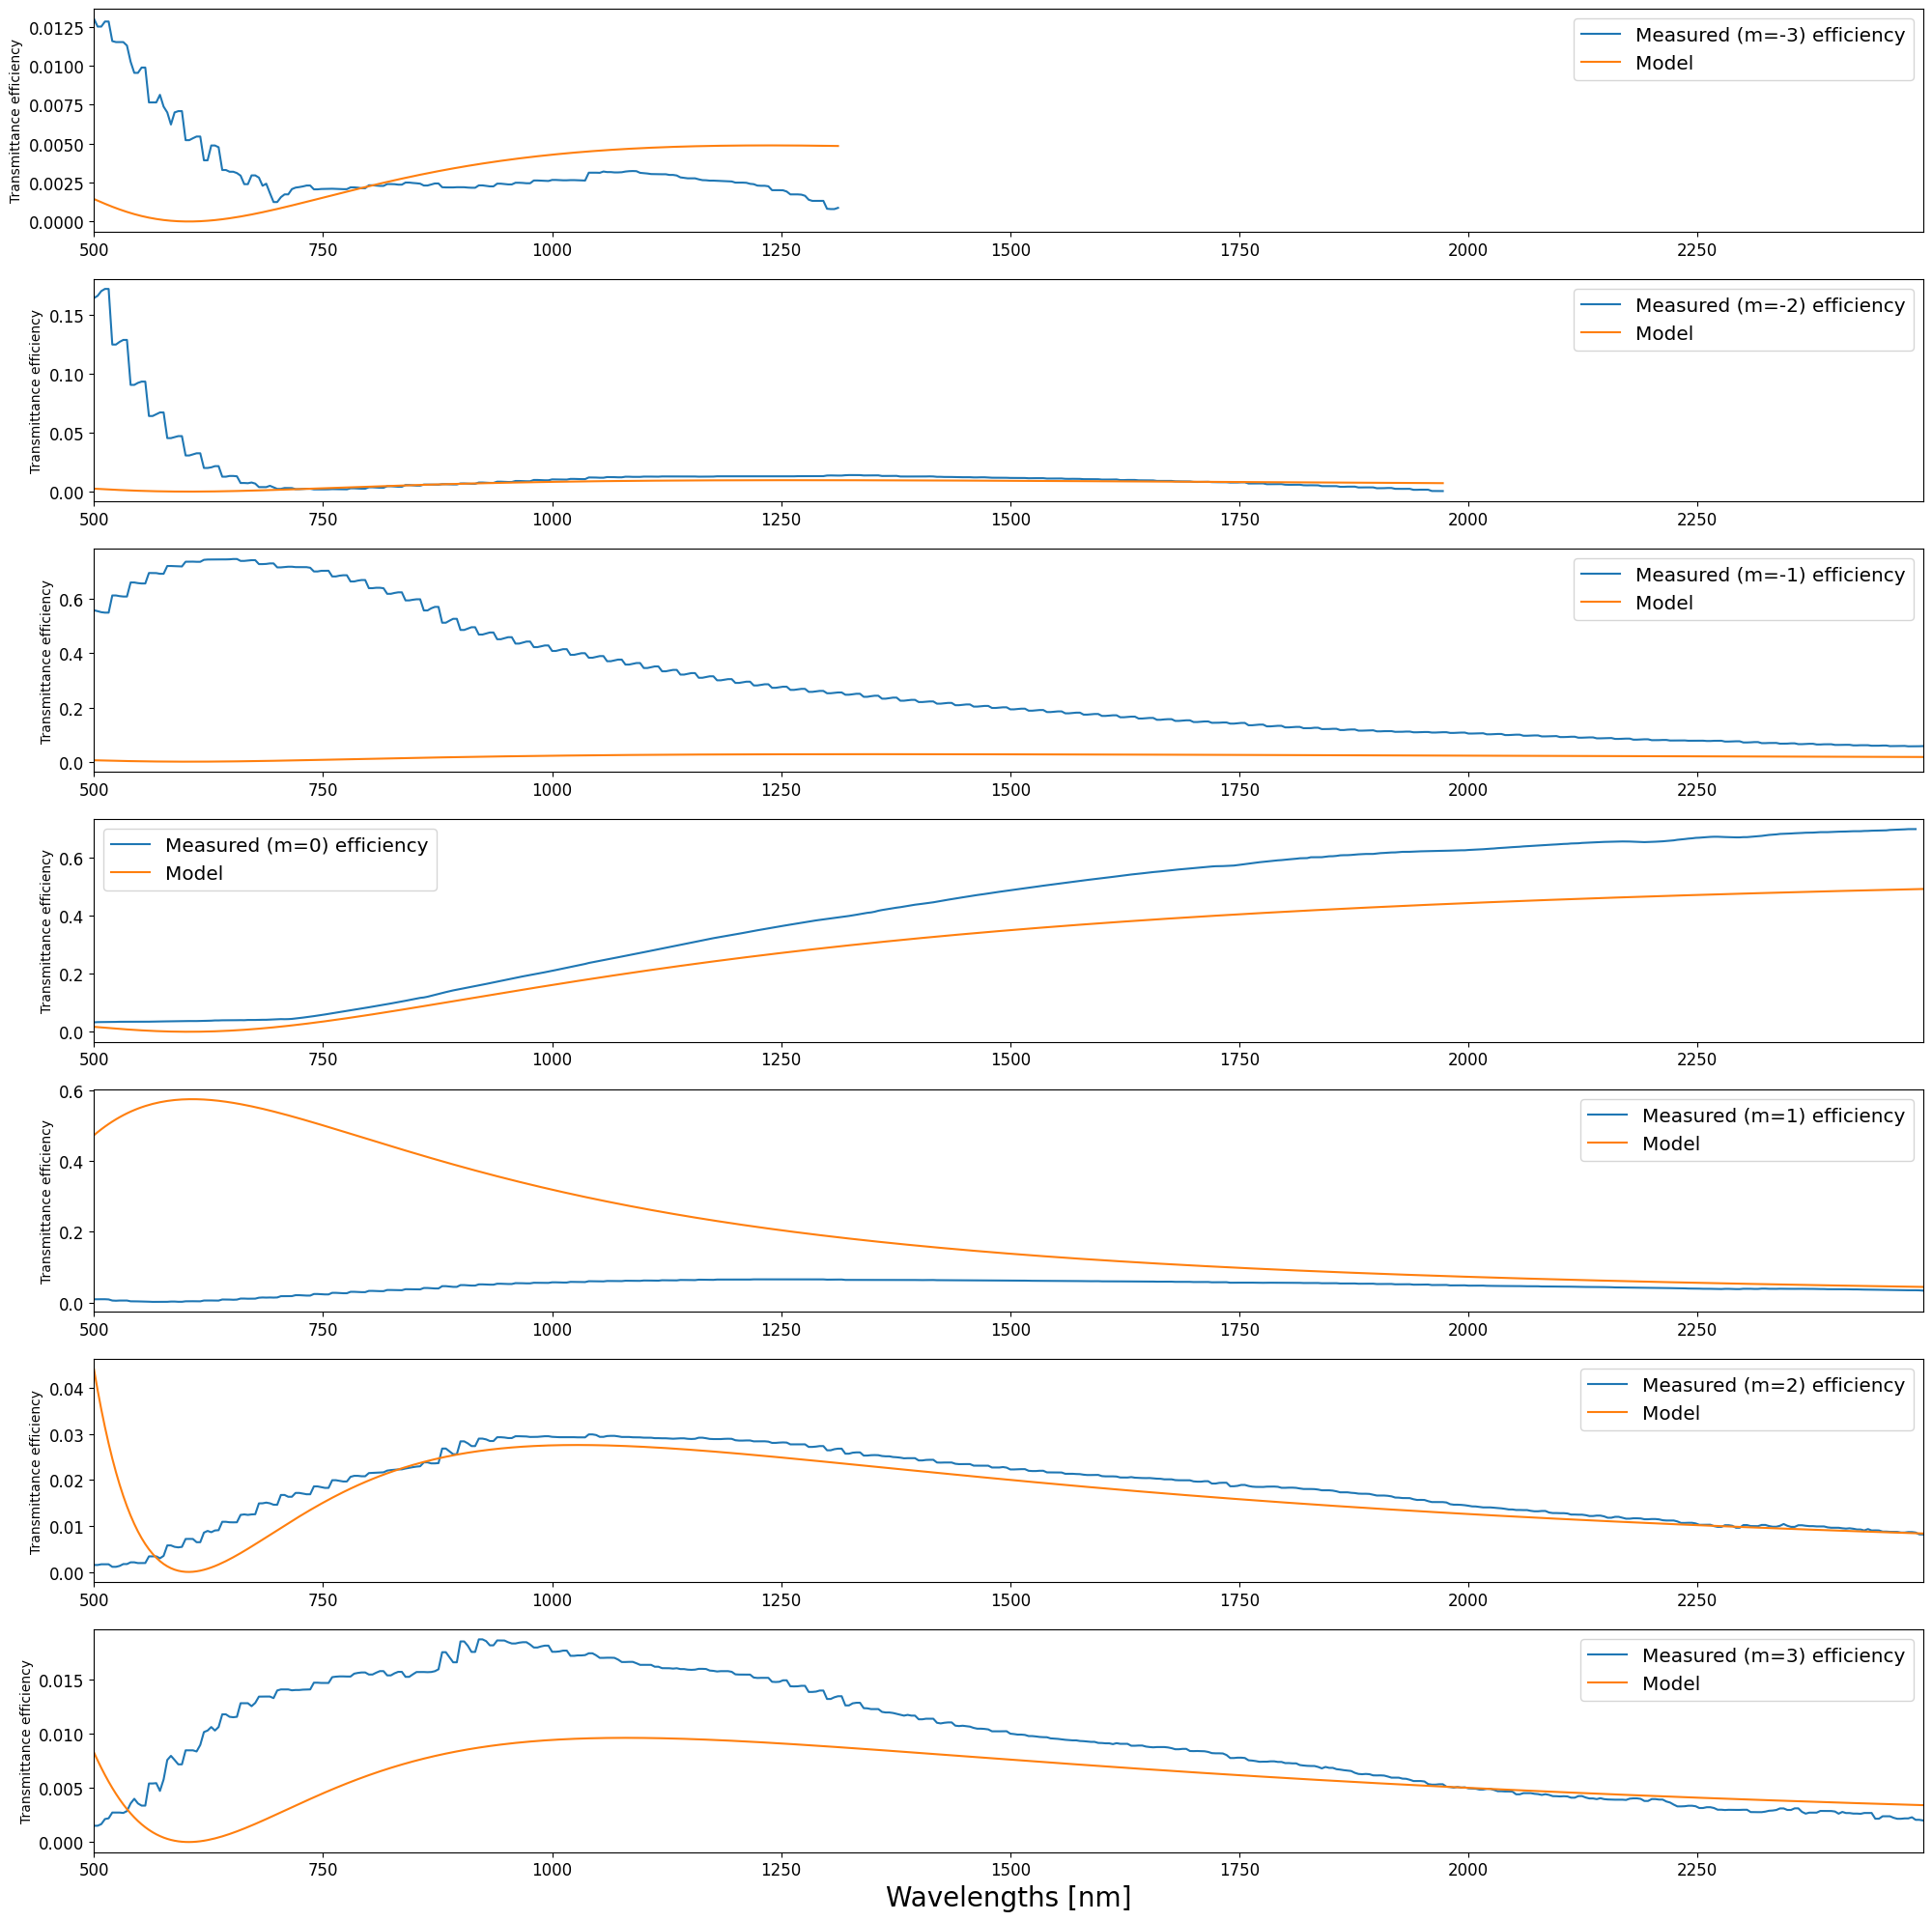

In [10]:
daidalos.show_envelope(incident_angles = [-20])

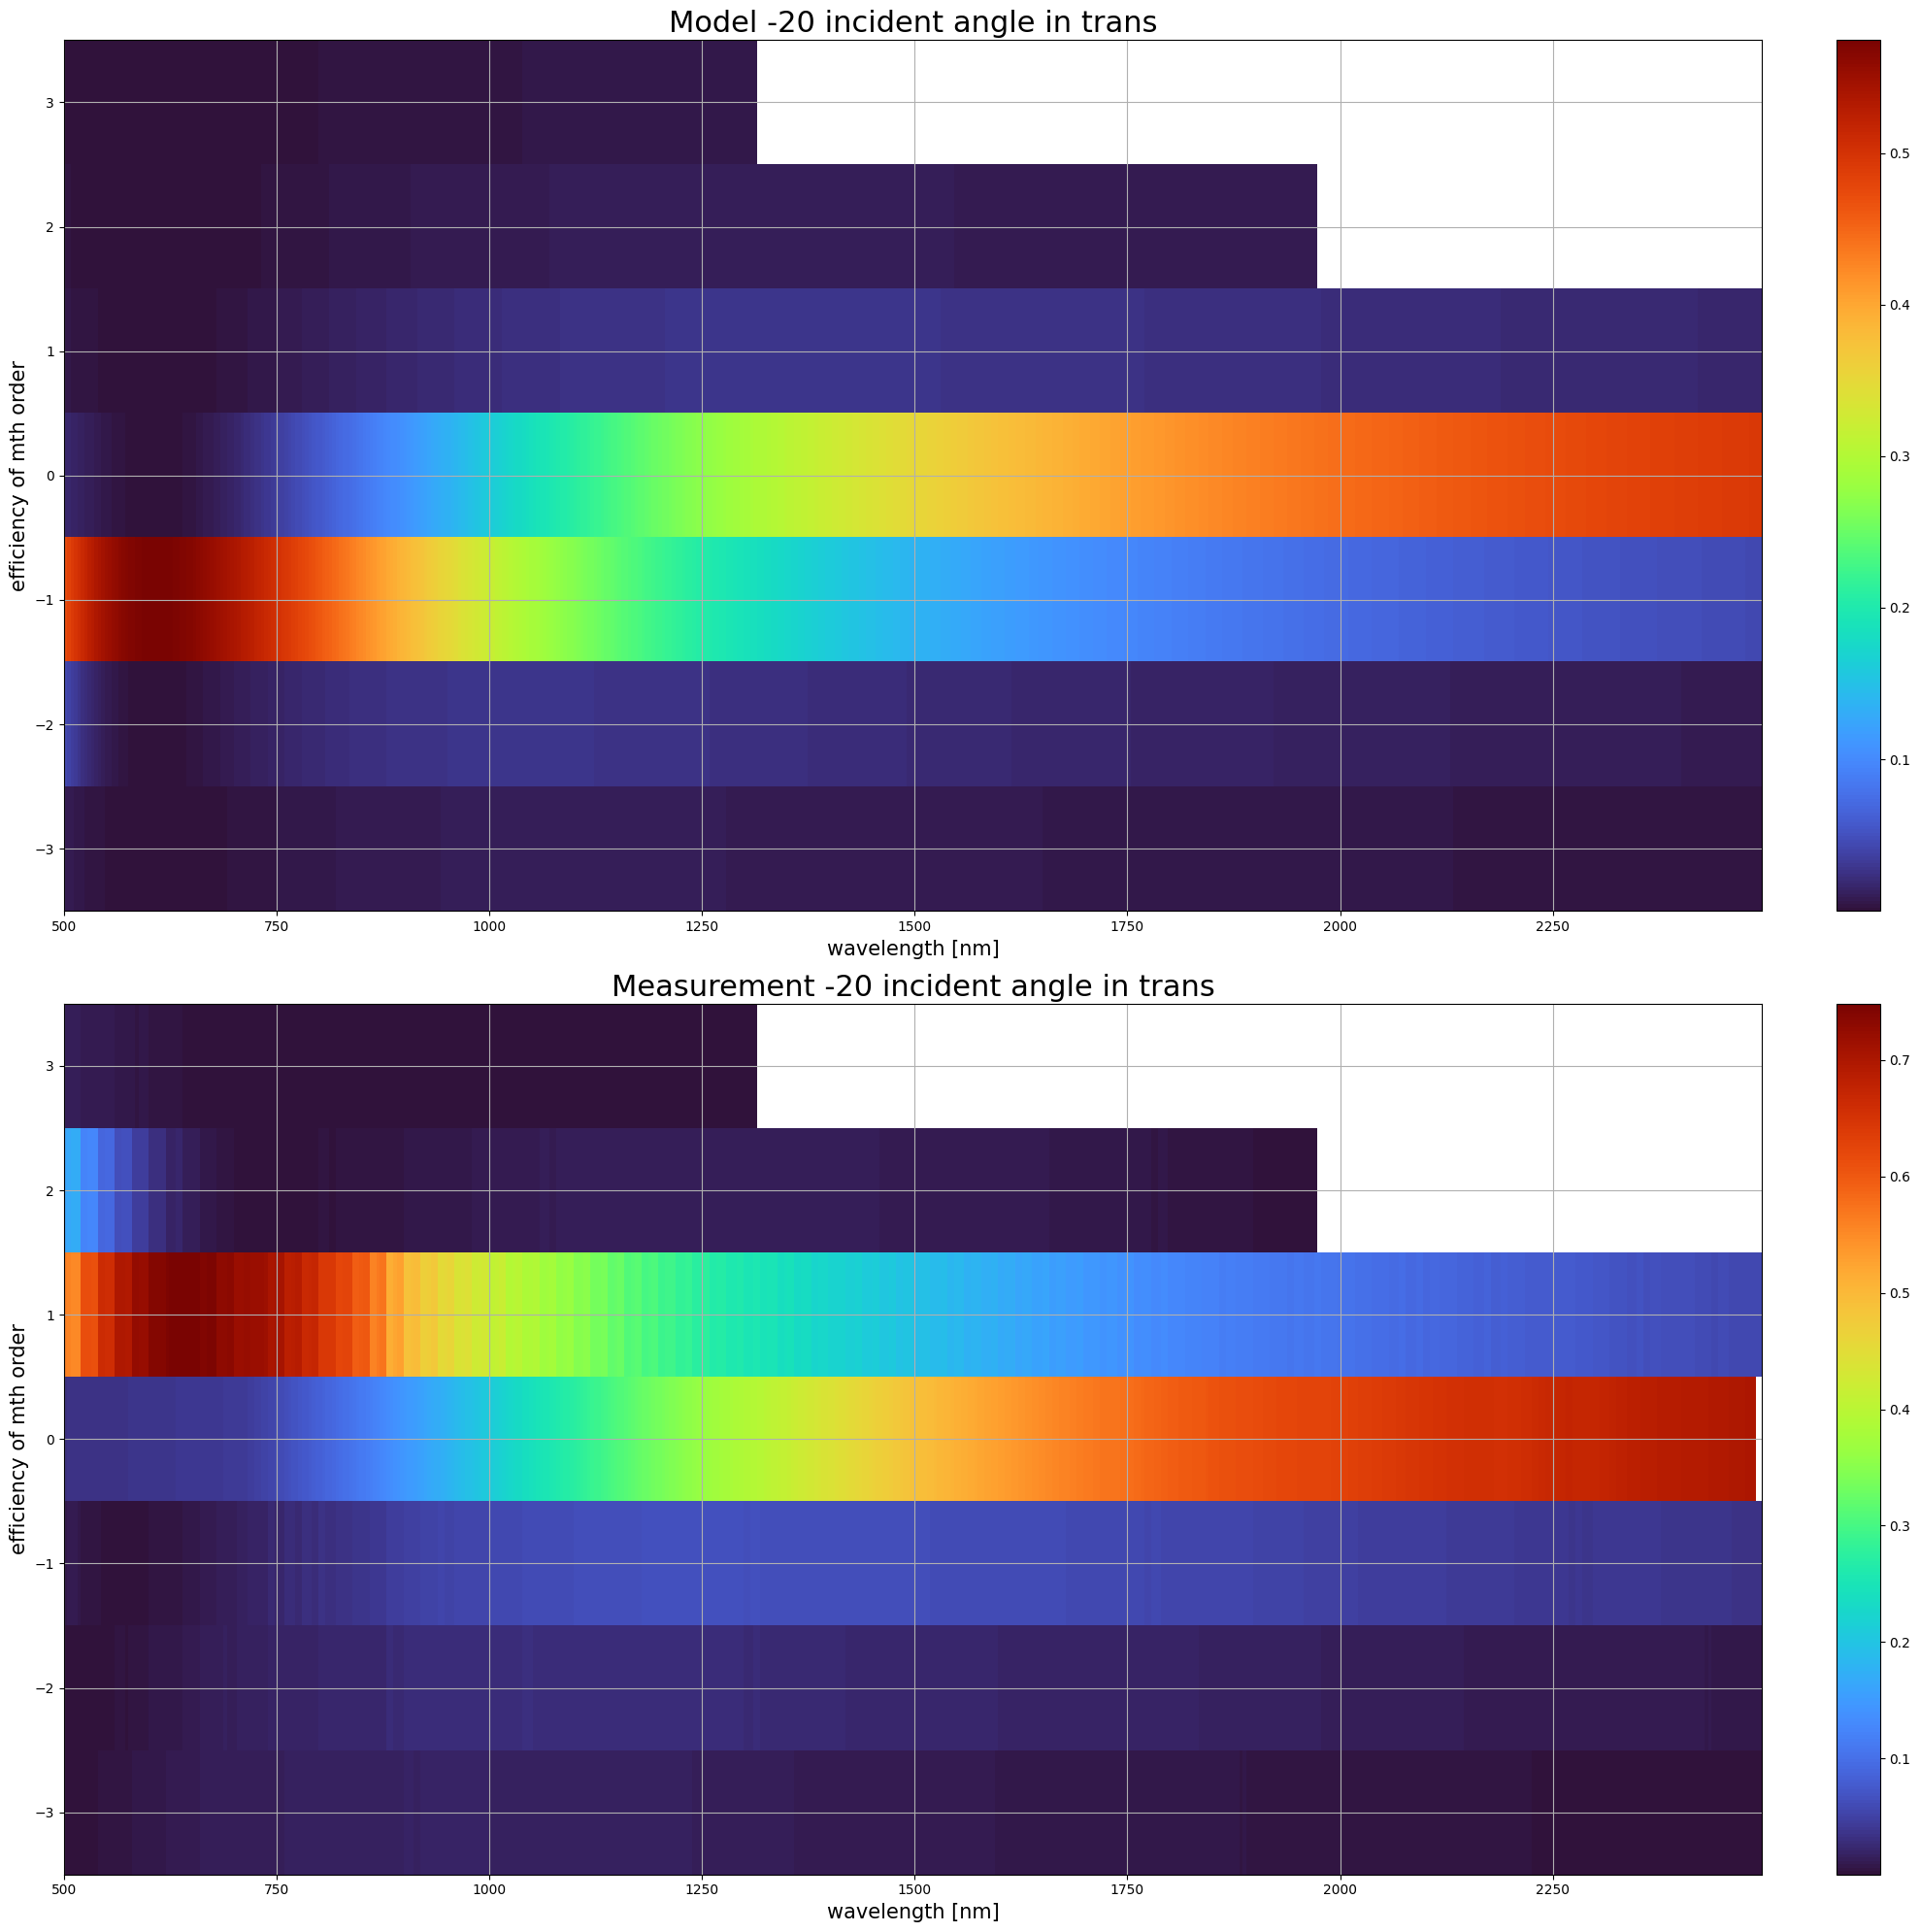

In [11]:
daidalos.compare(-20,'trans')

In [12]:
#daidalos2.show_diffraction(incident_angles = [0], mode = 'trans')